# K-means Clustering
Se trata de un algoritmo de aprendijaze no supervisado para la clasificación de datos

## Lectura de datos
Como paso preliminar examinaremos el dataset que estaremos utilizando, precisamente será el Mall Customer dataset

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random

file_name = "Mall_Customers.csv"
data = pd.read_csv(file_name)
data.head()

,CustomerID,Genre,Age,Annual_Income_(k$),Spending_Score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   CustomerID          200 non-null    int64 
 1   Genre               200 non-null    object
 2   Age                 200 non-null    int64 
 3   Annual_Income_(k$)  200 non-null    int64 
 4   Spending_Score      200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [9]:
data.describe()

,CustomerID,Age,Annual_Income_(k$),Spending_Score
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [8]:
data.corr()

,CustomerID,Age,Annual_Income_(k$),Spending_Score
CustomerID,1.000000,-0.026763,0.977548,0.013835
Age,-0.026763,1.000000,-0.012398,-0.327227
Annual_Income_(k$),0.977548,-0.012398,1.000000,0.009903
Spending_Score,0.013835,-0.327227,0.009903,1.000000


## Planteamiento del problema
En este caso se realizarán 3 análisis complementarios:
- Annual Income vs Spending Score
- Age vs Spending Score
- Annuual Inconme vs Age vs Spending Score

En todos se implementarán los algoritmos de clasificación no supervisada de manera manual, así como la implementación de la metodología del *codo* para hallar el número óptimo de agrupamientos para el problema.

Visualizaremos los datos que queremos clasificar mediante el algoritmo de *K-means*

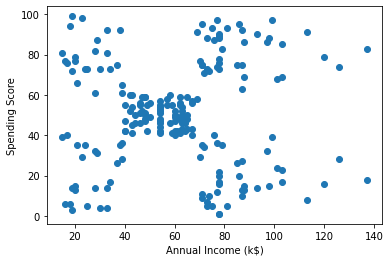

In [39]:
plt.scatter(data[['Annual_Income_(k$)']], data[['Spending_Score']])
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score')
plt.show()

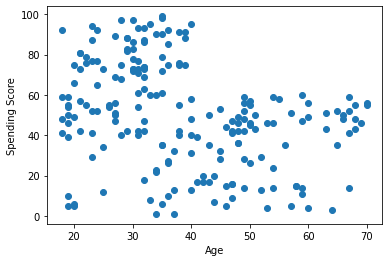

In [40]:
plt.scatter(data[['Age']], data[['Spending_Score']])
plt.xlabel('Age')
plt.ylabel('Spending Score')
plt.show()

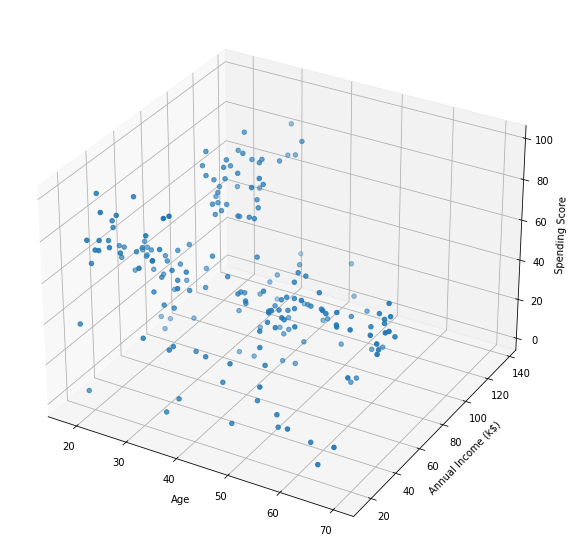

In [41]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[['Age']], data[['Annual_Income_(k$)']], data[['Spending_Score']])
plt.xlabel('Age')
plt.ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score')
plt.show()

In [70]:
X = list(data[['Annual_Income_(k$)', 'Spending_Score']].to_records(index=False))
print(np.shape(X))

(200,)


In [71]:
m = np.shape(data[['Age']])[0] #Número de datos
n = 2 #Caso de 2D
K = 5 #Cantidad de agrupamientos propuestos

centroids = np.array([]).reshape(n, 0)

#for k in range(K):
    #centroids=np.c_[centroids,X[random.randint(0, m-1)]] #Creamos los centroides de manera aleatoria


Calculamos la distancia euclidiana, expresada como:
<center>$$h$$

In [ ]:
out={}

# creating an empty array
e = np.array([]).reshape(m,0)

# finding distance between for each centroid
for k in range(K):
    distance=np.sum((X-centroids[:,k])**2,axis=1)
    e=np.c_[euclid,dist]

# storing the minimum value we have computed
minimum=np.argmin(euclid,axis=1)+1

In [ ]:



for i in range(n_iter):
    euclid=np.array([]).reshape(m,0)
    for k in range(K):
        dist=np.sum((X-centroids[:,k])**2,axis=1)
        euclid=np.c_[euclid,dist]
    C=np.argmin(euclid,axis=1)+1
    cent={}
    for k in range(K):
        cent[k+1]=np.array([]).reshape(2,0)
    for k in range(m):
        cent[C[k]]=np.c_[cent[C[k]],X[k]]
    for k in range(K):
        cent[k+1]=cent[k+1].T
    for k in range(K):
        centroids[:,k]=np.mean(cent[k+1],axis=0)
    final=cent

In [44]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=100, centers=5, random_state=101)
print(X)

[[ -4.95836863   5.96425277]
 [-10.56433263  -5.95908897]
 [  5.03973453  -5.91474793]
 [ -4.24393374   7.46294311]
 [  0.29639341   2.06317757]
 [ -1.37811338   0.25423232]
 [  3.74699958   6.26688185]
 [  4.60888633  -6.82802632]
 [ -9.2834887   -7.04901491]
 [ -9.04448516  -4.48554835]
 [  1.13567847   1.48631141]
 [ -8.43794202  -5.37732624]
 [ -8.46905731  -8.71077917]
 [ -1.69019569   2.15347379]
 [ -0.16913147   0.65928204]
 [  0.96675957   1.74299804]
 [  1.73293453   5.81105222]
 [  0.630638     3.10707466]
 [  6.18289166  -5.50567419]
 [ -0.61543385   1.89810338]
 [  4.3964456   -5.51281249]
 [ -3.62367998   8.07304206]
 [  4.15136702  -5.1385105 ]
 [ -0.80867204   1.41371822]
 [ -0.66529095   1.61015124]
 [ -4.11257256   7.29414134]
 [ -8.87174606  -5.5447566 ]
 [ -3.5550441    8.11543921]
 [  4.76174286  -7.26426981]
 [  0.85678605   0.8243512 ]
 [-10.81343557  -5.08707138]
 [  3.17306911   8.79566463]
 [  3.12439493  -7.83414491]
 [-10.43570239  -7.31135658]
 [-10.18584081

# Referencias
[1] https://www.machinelearningplus.com/predictive-modeling/k-means-clustering/
[2] https://matplotlib.org/stable/gallery/mplot3d/scatter3d.html
[3] https://www.kaggle.com/shrutimechlearn/step-by-step-kmeans-explained-in-detail/notebook
[4] https://www.analyticsvidhya.com/blog/2021/05/k-means-clustering-with-mall-customer-segmentation-data-full-detailed-code-and-explanation/